# Algoritmo Genético Ecléctico (EGA)
Daniel Alejandro Alonso Bastos

En el presente trabajo se realiza la implementación del EGA con cross validation para optimizar el valor de las potencias de las variables, de tal manera que se minimice el error ($\varepsilon_{RMS}$ o $\varepsilon_{MMX}$)

Hay un par de consideraciones importantes para que se logre la ejecución correcta del algoritmo:

- Se debe de tener en el mismo directorio del programa __EGA_FastAscentAlgorithm.py__ el archivo ejecutable ppmz2.exe para poder realizar la compresión de los archivos, y calcular el número de términos $n_{term}$
- Se debe de tener el programa __FastAscentAlgorithmFunctions.py__ en el mismo directorio del programa __EGA_FastAscentAlgorithm.py__, ya que en dicho programa se obtienen las funciones para ejecutar el __Fast Ascent Algorithm__

## Librerías

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import time
import shutil
import math
import plotly.graph_objects as go
import sys

import FastAscentAlgorithmFunctions as FAA # programa que contiene las funciones para ejecutar FAA

from IPython.display import display, Latex, Image

import warnings

#suppress warnings
warnings.filterwarnings('ignore')

## Lectura del archivo

El primer paso es que el usuario ingrese la ruta del archivo txt o csv con los datos a procesar, junto con el separador. La función _readData_ lee los datos y los transforma a un array para poder procesarlos en la ejecución de todo el programa. Nótese que para que el programa funcione es necesario que la estrcutura sea $x_1,x_2,...,x_n,f(x_1,x_2,...,x_n)$. Es decir, las primeras columnas son las variables independientes y la última columna es la variable dependiente.

In [2]:
def readData(path,delimiter='tab'):
    '''
    Funcion leer un archivo y hacer la separacion por tabulador si el usuario ingresa 'tab' o coma ','
    Nota: No soporta UTF-8
    
    Inputs:
    paht: str - Ruta del archivo a leer
    delimiter: str - 'tab' para separar datos con tabulador o ',' para separarlos por coma
    
    Return
    data: array - Estructura de tipo array para manipular los datos 
    '''
    try:
        if delimiter == 'tab':
            data = np.genfromtxt(path,delimiter='\t')
        elif delimiter == ',':
            data = np.genfromtxt(path,delimiter=',')
        # eliminar primer fila si es encabezado (cuando ocurre la primer fila es nan)
        ## revisar si algun elemento es nan, si es asi
        if len(np.unique(data[0])) == 1 and math.isnan(np.unique(data[0])):
            return data[1:]
        else:
            return data
    except:
        print('El separador seleccionado no es compatible')

Para encontrar el número de términos se emplean los pesos obtenidos de entrenar una red neuronal que está en función de las siguientes variables:

- Bias
- Número de tuplas
- Número de atributos
- Tamaño de compresión
- Ratio de compresión

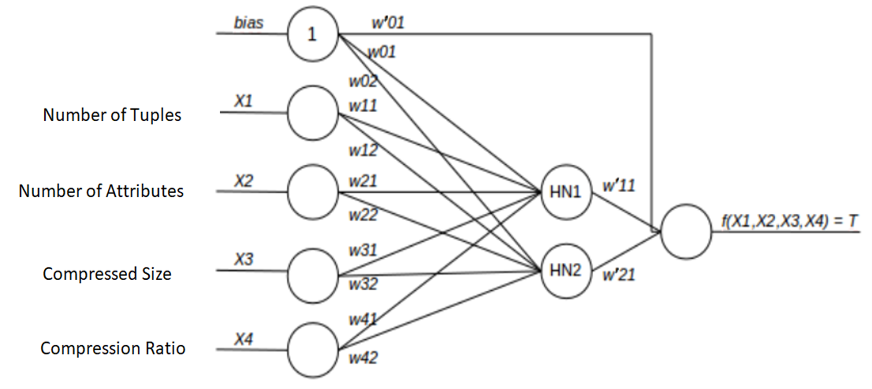
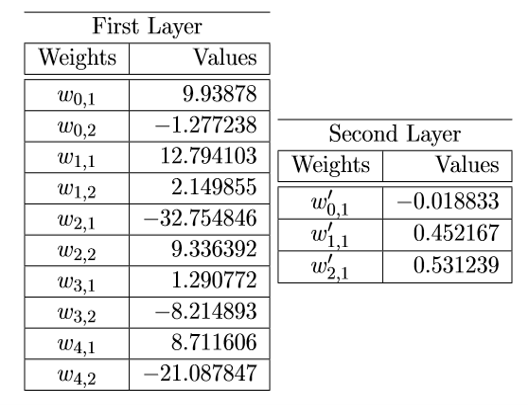

La función _findNumberTerms_ realiza las operaciones con los respectivos de la red neuronal para encontrar el número de términos $n_{term}$ aproximado para obtener una buena solución.

In [3]:
def findNumberTerms(path, delimiter='tab'):
    '''
    Calcula un estimado del numero de terminos del polimonio aproximante, utilizando los pesos de una
    red neuronal entrenada con multiples bases de datos.
    Los polinomios son calculados en funcion del: 
    - numero de atributos (n_attributes)
    - numero de tuplas (n_tuples)
    - tamanio del archivo comprimido (compressed_size)
    - razon de compresion (compression_ratio)
    
    Los valores son escalados para cada variable
    
    Inputs:
    paht: str - Ruta del archivo a leer
    delimiter: str - 'tab' para separar datos con tabulador o ',' para separarlos por coma
    
    Return:
    n_terms: int - Numero de terminos para el polinomio aproximante
    '''
    # leer archivo y calcular inputs
    data_file = readData(path, delimiter)
    ## numero de tuplas (filas) y atributos (columnas)
    bias = 1
    n_tuples, n_attributes = data_file.shape
    ## tamanio del archivo original
    file_size = os.path.getsize(path)
    ## compresion
    compressed_size = getCompressionSize(path)
    #compressed_size = 38056
    compression_ratio = file_size/compressed_size
    ## generar vector de inputs
    #print(f'{n_tuples},{n_attributes},{file_size},{compressed_size},{compression_ratio}')
    input_vector = np.array([bias,n_tuples,n_attributes,compressed_size,compression_ratio])
    
    # vectores (pesos establecidos en la red neuronal)
    ## vector con max y min por variable: [bias,n_tuples,n_attributes,compressed_size,compression_ratio,terms]
    max_min_per_variable = np.array([(0,0),(3134.5324164552,10.),(36.25644988969,1.356385937),
                               (258920.293929573,200),(38.0070218056,1.000),
                               (13.0207319789,1.0063476744)])
    ## pesos de la primera capa
    w_i1 = np.array([9.93878,12.794103,-32.754846,1.290772,8.711606])
    w_i2 = np.array([-1.277238,2.149855,9.336392,-8.214893,-21.087847])
    ## pesos de la segunda capa
    w_second_layer = np.array([-0.018833,0.452167,0.531239])
    
    # generar vector con los inputs escalados
    scaled_vector = np.ones(5) # inicializar
    ## iterar para cada variable a excepcion de bias y terms
    for i in range(1,5):
        max_var = max_min_per_variable[i,0] # limite superior
        min_var = max_min_per_variable[i,1] # limite inferior
        # revisar si se encuentra en los limites
        if (input_vector[i] <= max_var) and (input_vector[i] >= min_var):
            scaled = (input_vector[i]-min_var)/(max_var-min_var)
        else:
            # revisar si esta fuera de rango por arriba (poner 1) o por abajo (poner 0)
            if input_vector[i] > max_var:
                scaled = 1
            else:
                scaled = 0
        # actualizar vector de los inputs escalados
        scaled_vector[i] = scaled
    
    # operaciones con la primer capa oculta
    HN1 = np.dot(scaled_vector,w_i1)
    HN2 = np.dot(scaled_vector,w_i2)
    hidden_vector = np.array([1,HN1,HN2])
    ## aplicar funcion logistica
    hidden_vector_output = np.array([1,1/(1+np.exp(-HN1)),1/(1+np.exp(-HN2))])
    
    # operaciones en la capa de salida
    output_N = np.dot(hidden_vector_output,w_second_layer)
    ## aplicar funcion logistica
    output_N_log = 1/(1+np.exp(-output_N))
    
    # calcular numero de terminos
    ## limites superior e inferior para los terminos
    max_terms = max_min_per_variable[-1,0]
    min_terms = max_min_per_variable[-1,1]
    # re-escalar
    terms = output_N_log*(max_terms-min_terms)+min_terms
    # convertir a entero
    n_terms = int(terms+0.5)
    
    return n_terms

Las variables de número de tuplas y atributos se obtienen directo del archivo que se está procesando, pero en el caso del tamaño del archivo comprimido y la razón de compresión es necesario emplear un software adicional de compresión, en éste caso se utiliza el __High Compression Markov Predictive Coder__. El ejecutable del software se llama _ppmz2.exe_, y es ejecutado en la función _getCompressionSize_ para comprimir el archivo y obtener el tamaño del mismo, todo esto lo realiza en una carpeta temporal que después de calcular el tamaño del archivo comprimido, la carpeta temporal es eliminada.

Nótese que el ejecutable _ppmz2.exe_ es importante tenerlo en el mismo directorio que el programa __EGA_FastAscentAlgorithm.py__

Una vez calculado el tamaño del archivo comprimido, se puede obtener el ratio de compresión como:

\begin{equation}
    r_{comp} = \dfrac{size_{original}}{size_{comp}}
\end{equation}

In [4]:
def getCompressionSize(file_path):
    '''
    Funcion que comprime el archivo en file_path y regresa el tamanio despues de la compresion.
    Para ello:
        - Se crear una carpeta temporal de nombre temp_dir donde se realizara una copia del archivo original
        - Se comprime utilizando el ejecutable ppmz2.exe que se encuentra en la carpeta ppmz2
        - Se obtiene el tamnio resultante del archivo comprimido
        - Se elimina la carpeta temporal
    
    Inputs:
    file_path: str - Ruta del archivo a comprimir
    
    Return:
    comp_size: float - Tamanio del archivo comprimido
    '''
    # variables locales
    temp_dir = 'temp_comp' # nombre de la carpeta temporal para realizar las operaciones
    file_name = 'file2compress' # nombre de la copia del archivo para comprimir
    compress_name = 'compress' # nombre del archivo comprimido
    ext = os.path.splitext(file_path)[1] # extension del archivo
    cp_path = temp_dir + '/' + file_name + ext # direccion del archivo comprimido
    compress_path = temp_dir + '/' + compress_name + ext # direccion de la copia del archivo para comprimir
    
    # crear una carpeta temporal para guardar el archivo comprimido
    os.makedirs(temp_dir, exist_ok=True)
    # copiar archivo a comprimir a la carpeta temporal
    shutil.copy(file_path,cp_path)
    # comprimir archivo y guardar en la carpeta temporal
    os.system(r'ppmz2.exe ' + cp_path + ' ' + compress_path)
    # delay para evitar problemas de uso
    time.sleep(0.5)
    # tamanio del archivo comprimido
    comp_size = os.path.getsize(compress_path)
    # eliminar carpeta temporal
    shutil.rmtree(temp_dir)
    
    return comp_size

## Cross Validation

En esta sección se explicarán las funciones para utilizar cross validation en el EGA. La función _train_test_set_ separa el conjunto de datos original en dos conjuntos:
- El conjunto de entrenamiento que es el subconjunto donde se minimizará el error $\varepsilon$
- El conjunto de prueba, que es donde se estará probando el polinomio aproximante resultante del conjunto de entrenamiento, de tal manera que se irá registrando el error $\varepsilon$ de este conjunto también.

In [5]:
def train_test_set(data2split,train_pp=0.8,randomly_split=True):
    '''
    Funcion para separar un conjunto de datos en 3:
    - Conjunto de entrenamiento (train)
    - Conjunto de pruebas (test)
    
    Inputs:
    data2split: array - Arreglo con el conjunto de datos que se quiere separar
    train_pp: float - [0,1] Porcentaje de datos en el conjunto de entrenamiento (por default 80/20)
    randomly_split: boolean - bandera para identificar si los conjuntos de datos se seleccionan
        de manera aleatoria
    
    Return:
    train: array - Arreglo con el conjunto de datos de entrenamiento
    test: array - Arreglo con el conjunto de datos de prueba
    '''
    temp_data = data2split.copy() # generar una copia de data2split
    train_size = int(train_pp * len(temp_data)) # calcular el tamanio del conjunto de entrenamiento
    # en caso de generar los conjuntos de manera aleatoria -> barajear datos
    if randomly_split: np.random.shuffle(temp_data)
    
    # generar conjuntos
    train = temp_data[:train_size]
    test = temp_data[train_size:]
    
    return train, test

La función _evaluateCoefError_ calcula el valor de los coeficientes del polinomio aproximante, los errores $\varepsilon_{MMX}$ y $\varepsilon_{RMS}$ al llamar al algoritmo FAA dado un conjunto de datos y las potencias de las variables de cada monomio.

In [6]:
def evaluateCoefError(data_matrix,coef_comb,stabilize_data,stabilize_factor,quasi_factor,max_iterations):
    '''
    Funcion para calcular el valor de los coeficientes, error minimax y rms 
    dado un conjunto de datos y la potencia de las variables
    
    Inputs:
    data_matrix: array - matriz con los datos a analizar (se considera que la ultima columna es f(X))
    coef_comb: list - lista con las potencias a probar
    stabilize_data: boolean - bandera que indica si se desea estabilizar los datos (True por default)
    stabilize_factor: float - factor de estabilizacion
    quasi_factor: float - factor para una convergencia de FAA, p.ej., si es 0.05, el algoritmo converge cuando e_phi
        tiene una diferencia menor del 5% de e_theta. Ayuda a terminar el algoritmo mas rapido
    max_iterations: int - numero maximo de iteraciones permitido, para que el programa se detenga en caso de no converger
    
    Return:
    coef_values: list - lista con el valor de los coeficientes
    e_mmx: float - Error minimax
    e_rms: float - Error RMS
    '''
    # calcular e_rms de la lista de potencias a las que se eleva cada variable   
    C,_,e_rms = FAA.FAA_M(data_matrix,coefficient_list=coef_comb,stabilize_data=stabilize_data,
                          stabilize_factor=stabilize_factor,quasi_factor=quasi_factor,
                          max_iterations = max_iterations,plot_results=False,save_results=False)
    e_mmx = C[0] # error minimax
    coef_values = C[1:] # valor de los coeficientes
    return coef_values, e_mmx, e_rms

La función _evaluatePolynomial_ evalúa el polinomio aproximante en un conjunto de datos, tal que obtiene los errores $\varepsilon$

In [7]:
def evaluatePolynomial(data_set,coef_values,coef_degrees):
    '''
    Funcion para evaluar el polinomio aproximante en un conjunto de datos.
    El polinomio aproximante esta compuesto por los valores de los coeficientes (coef_values) y
    la lista de exponentes de cada variables
    
    Inputs:
    data_set: array - arreglo con el conjunto de datos en el que se evaluara el polinomio
    coef_values: list - lista con el valor de los coeficientes
    coef_degrees: list - lista con la potencia de cada variable por cada termino
    
    Return:
    y: array - vector con los valores originales de la variable dependiente
    y_hat: array - vector con los valores aproximados de la variable dependiente
    e_mmx: float - error minimax del polinomio sobre el conjunto de datos
    e_rms: float - error RMS del polinomio sobre el conjunto de datos
    '''
    # obtener conjunto de valores reales -> y (ultima columna)
    y = data_set[:,-1]
    # evaluar el polinomio en el data_set
    # el polimonio consiste en el valor de los coeficientes y la potencia de cada variable
    y_hat_list = [] # inicializar lista para guardar los valores aproximados y_hat
    ## iterar para cada tupla del conjunto de datos
    for row in range(len(data_set)):
        y_temp = 0 # inicializar variable para guardar el y_hat para cada tupla
        for i in range(len(coef_values)): # iterar para cada coeficiente
            value = coef_values[i] # inicializar value -> con el valor del i-esimo coeficiente
            for j in range(len(coef_degrees[i])): # elevar cada variable con su respectiva potencia
                value *= data_set[row,j] ** coef_degrees[i][j]
            y_temp += value # agregar valores de las variables elevadas a su potencia
        y_hat_list.append(y_temp) # agregar valor a la lista de y_hat
    
    # calcular errores mmx y rms
    ## e_mmx
    y_hat = np.array(y_hat_list) # convertir a array para realizar las operaciones
    diff_abs = abs(y-y_hat) # diferencia absoluta
    e_mmx = max(diff_abs) # e_mmx es el maximo de las diferencias
    
    ## e_rms
    e_rms = np.sqrt(np.mean(diff_abs**2))
        
    return y, y_hat, e_mmx, e_rms

## EGA

El algoritmo EGA sigue los pasos mostrados en la siguiente figura:

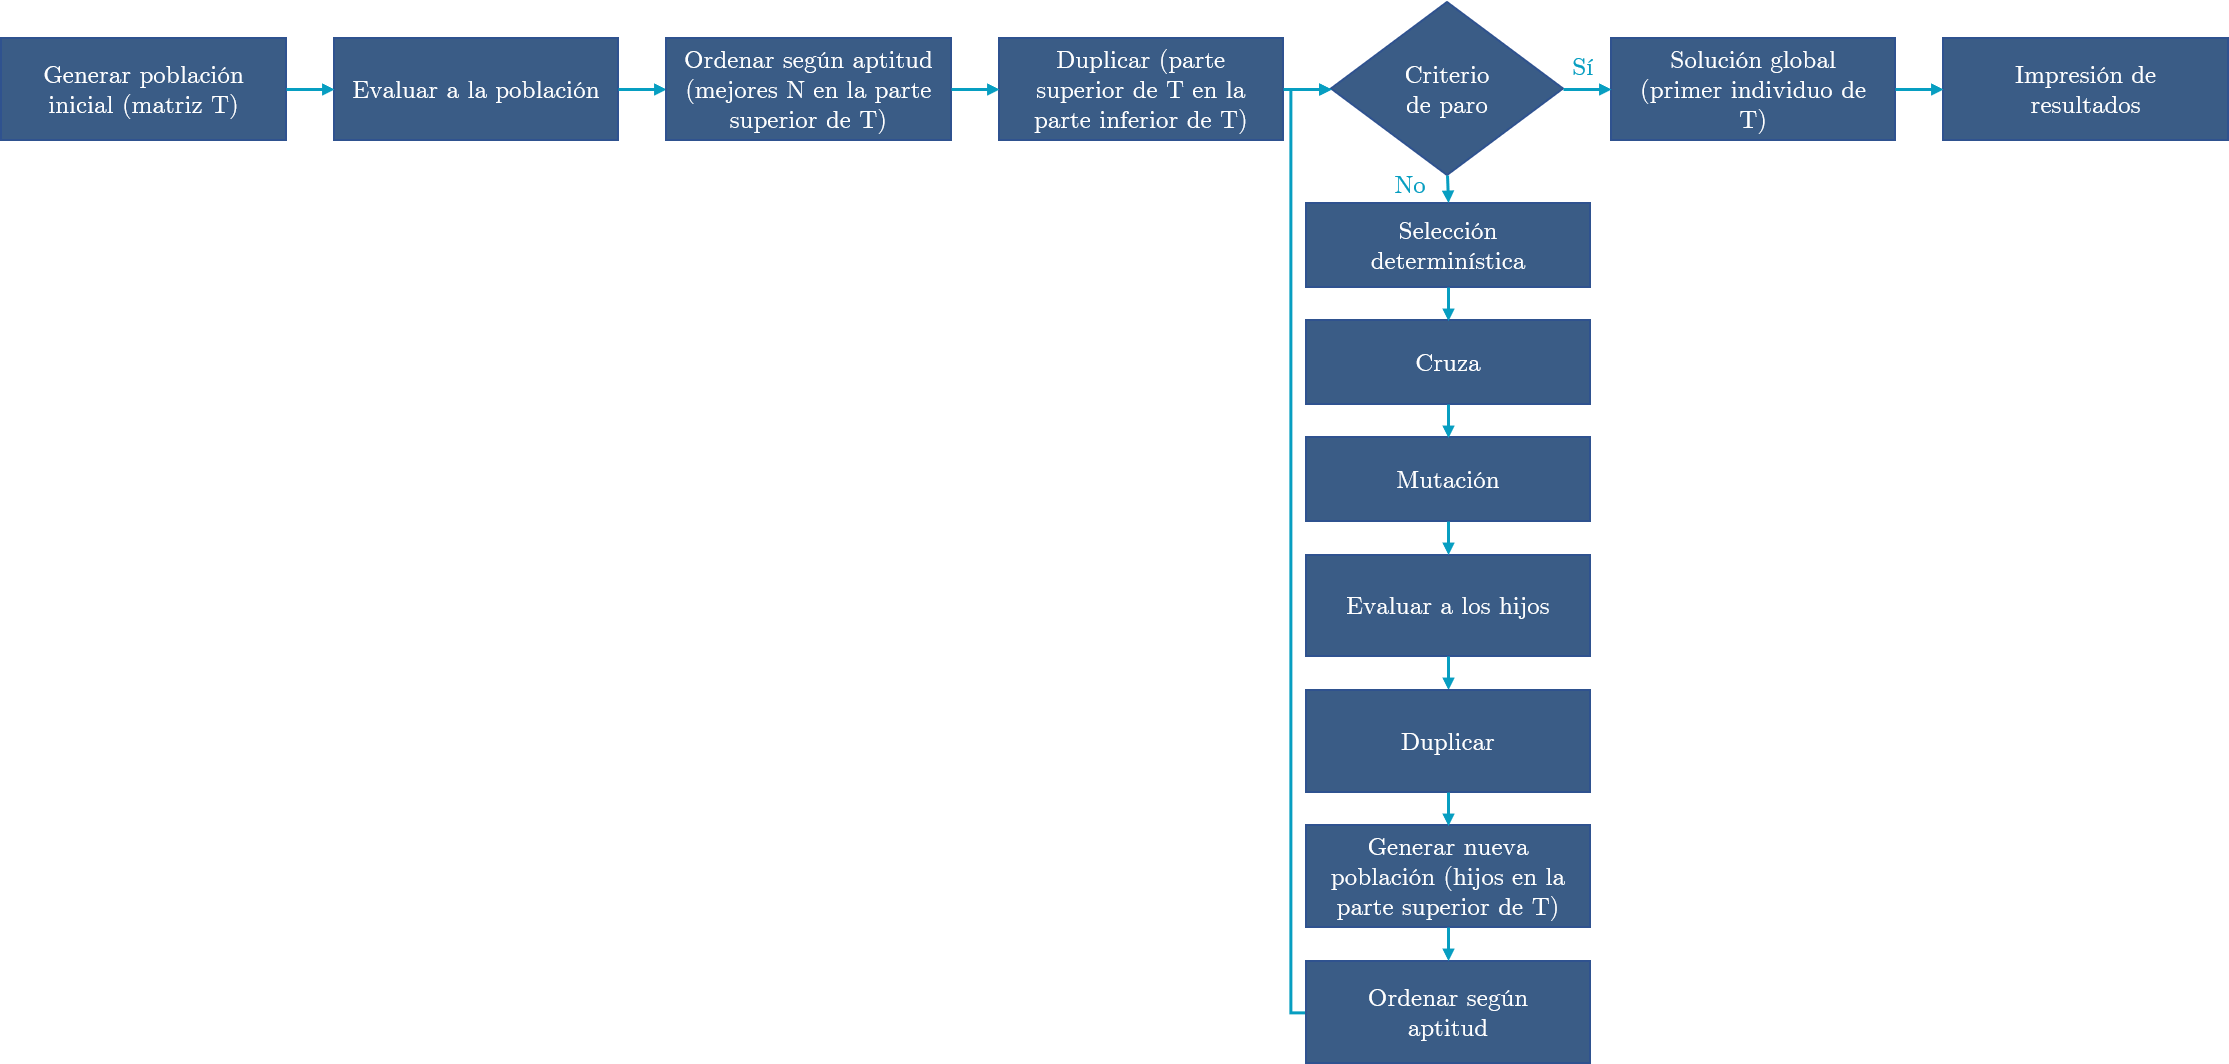

En el cual:
- El elitismo es completo, ya que se conservan los $N$ mejores individuos de cada generación, siendo el primer individuo el mejor.
- La selección es determinística cruzando con una probabilidad $P_c$ el $i$-ésimo con el $(N-i)$-ésimo individuo
- La cruza es aleatoria anular con anillos de tamaño $L/2$
- La mutación es uniforme sobre el número esperado de mutaciones en una población con probabilidad $P_m$

### Generación de una población inicial aleatoria que cumple con los requisitos

Un individuo de la población del EGA consiste en una secuencia de enteros que representan las potencias de cada una de las variables de una colección de términos. Es importante que la suma de las potencias representen una muestra sin sesgo y que pertenezan a $L$, donde:

\begin{equation}
L=\begin{bmatrix}
1 & 11 & 33 & 63\\ 
3 & 15 & 35 & 77\\ 
5 & 21 & 45 & 81\\ 
7 & 25 & 49 & 99\\ 
9 & 27 & 55 & 121
\end{bmatrix}
\end{equation}

Para ello, se genera una población de individuos con la potencia de cada término, seleccionado de una distribución gaussiana, de manera que $P(0\leq D\leq121)\approx0.95$.

Por lo tanto, el primer paso es realizar un vector $D$ por individuo que contenga la suma de potencias de cada término y que $\in L$, p.ej.,para un individuo de 10 términos:

\begin{equation}
   D = [0,1,5,9,15,21,21,55,55,99]
\end{equation}

La función _generateD_ realiza dicha operación, es decir, genera un vector aleatorio con distribución gaussiana de potencias $\in L$, dicho vector tiene el tamaño del número de términos $n_{term}$ calculado anteriormente.

In [8]:
global L
L = [0,1,3,5,7,9,11,15,21,25,27,33,35,45,49,55,63,77,81,99,121]

In [9]:
def generateD(n_terms,max_monomial_degree=121,distribution='normal'):
    '''
    Funcion que genera un vector de tamanio n_terms de potencias aleatorias con distribucion gaussiana (por default)
    que estan en la matriz L. P.ej.: [0,1,5,9,15,21,21,55,55,99]
    
    Inputs:
    n_terms: int - Numero de terminos para el polinomio aproximante
    max_monomial_degree: int - grado maximo del monomio
    distribution: str - 'normal' para obtener uns distribucion normal al seleccionar cada potencia, 
        si se busca una distribucion uniforme -> 'uniform'
    
    Returns:
    D: list - vector con potencias aleatorias
    '''
    # filtrar L de tal manera que se tengan las potencias <= max_degree -> L_filtered
    L_filtered = [] # inicializar
    for d in L:
        if d <= max_monomial_degree:
            L_filtered.append(d)
        else:
            break
    
    # generar una lista aleatoria con la suma de potencias de tamanio n_terms
    l = len(L_filtered) # longitud de la lista filtrada
    D = [] # inicializar vector D para guardar las potencias
    if distribution == 'normal': # con distribucion normal
        while len(D) < n_terms: # ejecutar hasta tener los n_terms
            sample_idx = int(random.gauss(l/2,l/2)) # generar una muestra, que representa el indice
            if sample_idx >= 0 and sample_idx <=l-1: # validar que se encuentre la muestra entre [0,l-1]
                D.append(L_filtered[sample_idx]) # agregar a la lista D el valor de la lista filtrada en el idx sample
    else: # con distribucion uniforme
        for i in range(n_terms):
            sample_idx = random.randint(0,l-1) # generar una muestra, que representa el indice
            D.append(L_filtered[sample_idx]) # agregar a la lista D el valor de la lista filtrada en el idx sample
                
    return sorted(D)

Una vez obtenido el vector $D$, se transforma ese vector en un vector con una combinación de las potencias a las que se eleva cada variable por término, p.e., para un inidividuo de 5 términos y 4 variables independientes:

\begin{equation}
    [0,1,5,9,15] \rightarrow [[0,0,0,0],[0,1,0,0],[5,0,0,0],[2,3,0,2],[15,0,0,0]]
\end{equation}

Para realizar dicha transformación se utiliza la función _generateTerms_. Y a su vez, la función _generateTerms_ emplea a la función _generateTerm_ que genera un solo término al tomar como entrada el valor de una potencia.

In [10]:
def generateTerms(list_D,n_ind_variables,max_degree=121,distribution='normal'):
    '''
    Funcion que transforma el vector D en un vector con las potencias de cada variable para cada termino. 
    P.ej., para un vector de 5 terminos y 4 variables independientes:
    [0,1,5,9,15] -> [[0,0,0,0],[0,1,0,0],[5,0,0,0],[2,3,0,2],[15,0,0,0]]
    
    Inputs:
    list_D: list - vector con potencias
    n_ind_variables: int - numero de variables independientes
    max_degree: int - maximo exponente que puede tener una variable
    distribution: str - 'normal' para obtener uns distribucion normal al seleccionar cada expoenente, 
        si se busca una distribucion uniforme -> 'uniform'
        
    Returns:
    terms_array: list - lista con las potencias de cada variable por cada termino (se hace lo posible por
        no tener duplicados y que la suma de las potencias se encuentre en L)
    '''
    # iniciliazar lista
    terms_array = []
    max_iterations = 100 # numero maximo de iteraciones para encontrar un termino no repetido en terms_array
    
    # iterar para todo el vector D
    for i in range(len(list_D)):
        run = True # inicializar ciclo while
        iterations=0 # inicializar numero de iteraciones (iteraciones para encontrar un termino no repetido)
        # ejecutar hasta no tener repetidos en terms_list y que la suma de coef este en
        # en la lista de terminos unicos L (variable global)
        while run:
            # generar un termino que cumpla con las condiciones
            term = generateTerm(n_ind_variables, max_degree=max_degree, 
                                max_monomial_degree=list_D[i],distribution=distribution)
            # sumar las potencias del termino para validar que se encuentre en L
            sum_terms = np.array(term).sum()
            # validar que el termino no este duplicado y que la suma de las potencias este en L
            if (term not in terms_array) and (sum_terms in L):
                # en caso de cumplir, agregar el termino a terms_array y romper el ciclo
                terms_array.append(term)
                break
            # en caso de no cumplir con las condiciones, aumentar las iteraciones e intentar de nuevo
            iterations += 1
            # en caso de llegar al maximo numero de iteraciones, agregar el termino y romper el ciclo
            # evitar un ciclo infinito
            if iterations == max_iterations:
                terms_array.append(term)
                break
    
    return terms_array

In [11]:
def generateTerm(n_ind_variables, max_degree=121, max_monomial_degree=121, distribution='normal'):
    '''
    Funcion para generar un termino de tamanio del numero de las variables independientes que cumpla con 
    las restricciones del valor maximo de las potencias de cada variable, y el grado maximo del polinomio
    
    Inputs:
    n_ind_variables: int - numero de variables independientes
    max_degree: int - maximo exponente que puede tener una variable
    max_monomial_degree: int - grado maximo del monomio
    distribution: str - 'normal' para obtener uns distribucion normal al seleccionar cada expoenente, 
        si se busca una distribucion uniforme -> 'uniform'
    
    Return:
    term: list - Lista con el exponente de cada una de las variables independientes
    
    '''
    # inicializar lista donde se guardaran las potencias de cada variable
    term = []
    max_val = max_monomial_degree # grado maximo que el monomio puede tener
    
    # iterar para cada variable independiente
    for i in range(n_ind_variables): # generar un termino de tamanio del numero de variables independientes
        # revisar que max_degree todavia este en intervalo
        if max_degree > max_val: max_degree = max_val
        if max_val !=0: # si todavia no se alcanza el maximo grado del monomio
            if distribution == 'normal': # si se utiliza una distribucion normal
                temp_val = int(random.gauss(max_degree/2,max_degree/2))
                while temp_val < 0 or temp_val > max_degree: # verificar que este en el rango [0,max_degree]
                    temp_val = int(random.gauss(max_degree/2,max_degree/2))
            else: # distribucion uniforme
                temp_val = random.randint(0,max_degree) # generar un numero aleatorio entre [0,max_degree]    
            max_val = max_val-temp_val # actualizar max_val
        else: # en caso de alcanzar el maximo grado del monomio
            temp_val = 0
        # agregar valor al termino (actualizar termino)
        term.append(temp_val)
    
    return term

Una vez que se tienen las funciones auxiliares que ayudan para crear a un individuo, se realiza la función _generatePopulation_ que genera una población de $N_{individuos}$, donde para cada individuo se le genera un vector $D$ de manera aleatoria con distribución gaussiana, y después ese vector es transformado en un vector que contiene las potencias a las que se eleva cada variable independiente en cada término.

In [12]:
def generatePopulation(n_ind,n_terms,n_ind_variables,max_degree=121,
                       max_monomial_degree=121,distribution='normal'):
    '''
    Funcion para generar a una poblacion de n_ind individuos, y para cada individuo se crea un vector D y se transforma
    en un vector que contiene las potencias a las que se eleva cada variable independiente para cada termino
    
    Inputs:
    n_ind: int- numero de individuos
    n_terms: int - numero de terminos
    n_ind_variables: int - numero de variables independientes
    max_degree: int - maximo exponente que puede tener una variable
    max_monomial_degree: int - grado maximo del monomio
    distribution: str - 'normal' para obtener uns distribucion normal al seleccionar cada expoenente, 
        si se busca una distribucion uniforme -> 'uniform'
    
    Return:
    population: list - Lista con los polinomios de cada individuo
    '''
    # inicializar lista para guardar los valores de la poblacion
    population = []
    # iterar para cada individuo
    for i in range(n_ind):
        # crear el vector de grados D
        D = generateD(n_terms,max_monomial_degree=max_monomial_degree,distribution=distribution)
        # crear un vector de las potencias para cada variable
        DT = generateTerms(D,n_ind_variables,max_degree=max_degree,distribution=distribution)
        # agregar a la matriz de poblacion
        population.append(DT)
    return population

### Evaluación

Para realizar la evaluación, lo primero que se tiene que definir es la función objetivo _objective_, la cual toma como entrada los datos y el vector de polinomios (vector que contiene las potencias de cada variable de cada término), con eso se ejecuta el Fast Ascent Algorithm para calcular el error $\varepsilon_{RMS}$ o $\varepsilon_{MMX}$.

Además se agrega una penalización en caso de que la suma de los exponentes de las variables $\notin L$

In [13]:
def objective(data_matrix,coef_comb,stabilize_data,stabilize_factor,error='rms',quasi_factor=0.0,max_iterations=1000):
    '''
    Funcion objetivo -> Devuelve el error rms o minimax del polimonio coef_comb al resolver por FAA
    
    Inputs:
    data_matrix: array - matriz con los datos a analizar (se considera que la ultima columna es f(X))
    coef_comb: list - lista con las potencias a probar
    error: str - 'rms' si se quiere minimizar el error rms o 'mmx' si se quiere el error minimax
    stabilize_data: boolean - bandera que indica si se desea estabilizar los datos (True por default)
    stabilize_factor: float - factor de estabilizacion
    quasi_factor: float - factor para una convergencia de FAA, p.ej., si es 0.05, el algoritmo converge cuando e_phi
        tiene una diferencia menor del 5% de e_theta. Ayuda a terminar el algoritmo mas rapido
    max_iterations: int - numero maximo de iteraciones permitido, para que el programa se detenga en caso de no converger
    
    Returns:
    fitness: float - valor de aptitud (error seleccionado + penalizacion)
    '''
    # calcular e_rms de la lista de potencias a las que se eleva cada variable    
    C,_,e_rms = FAA.FAA_M(data_matrix,coefficient_list=coef_comb,stabilize_data=stabilize_data,
                      stabilize_factor=stabilize_factor,quasi_factor=quasi_factor,
                      max_iterations = max_iterations,plot_results=False,save_results=False)
    
    # penalizar si la suma de potencias de cada termino no esta en L
    penalize = 0
    for term in coef_comb:
        sum_terms = np.array(term).sum()
        if sum_terms not in L:
            penalize += 1e6
            
    # calcular fitness
    if error == 'rms':
        fitness = e_rms + penalize
    else:
        fitness = C[0] + penalize

    return fitness

Una vez generada la función objetivo, como paso en el EGA se evalúa cada individuo de la población con la función _evaluate_

In [14]:
def evaluate(population,data_matrix,stabilize_data,stabilize_factor,error='rms',quasi_factor=0.0,max_iterations=1000):
    '''
    Funcion para evaluar a cada individuo de la poblacion (definiendo una funcion objetivo -> objective)
    
    Inputs:
    population: list - lista de los individuos de la poblacion
    data_matrix: array - matriz con los datos a analizar (se considera que la ultima columna es f(X))
    error: str - 'rms' si se quiere obtener el error rms o 'mmx' si se quiere el error minimax
    quasi_factor: float - factor para una convergencia de FAA, p.ej., si es 0.05, el algoritmo converge cuando e_phi
        tiene una diferencia menor del 5% de e_theta. Ayuda a terminar el algoritmo mas rapido
    max_iterations: int - numero maximo de iteraciones permitido, para que el programa se detenga en caso de no converger
    
    Returns:
    void: La funcion no retorna nada como tal, solo agrega una columna a cada individuo con el valor de su aptitud
    '''
    # iterar para cada individuo en la poblacion
    for individual in population:
        # calcular aptitud del individuo
        fitness = objective(data_matrix,individual,stabilize_data,stabilize_factor,error,quasi_factor,max_iterations)
        # agregar valor de aptitud al individuo
        individual.append(fitness)

### Operadores genéticos - Cruza

La selección para realizar la cruza es de manera determinística, es decir, la cruza se realiza entre el primer y último individuo $N$, la siguiente cruza se realiza entre el segundo y el penúltimo y así sucesivamente. De forma general se cruza el $i$-ésimo con el $N-i$-ésimo individuo, donde $i \in [0...N-1]$. Una vez seleccionados los individuos a cruzar (padres) se realiza la cruza con cierta probabilidad de cruza $P_c$, en caso de no darse la cruza entonces los hijos son idénticos a los padres, y en caso de darse la cruza entonces se seleccionan un par de puntos de cruza distintos y ordenados de manera aleatoria entre $[0...n_{terms}]$, al tener ambos puntos de cruza se intercambian los términos entre ambos individuos de tal manera que se generan dos nuevos individuos (hijos), tal como se muestra en el siguiente diagrama:

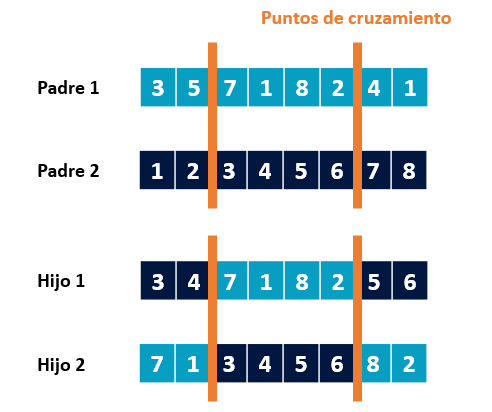

La función _crossover_ realiza tanto la selección como la cruza dada una cierta probabilidad. La función toma como entrada una población de $N$ individuos, y retorna otra población de $N$ hijos.

In [15]:
def crossover(population,cross_probability):
    '''
    Funcion para seleccionar y cruzar los individuos de una poblacion dada una cierta probabilidad.
    
    Inputs:
    population: list - lista de los individuos de la poblacion (sin el valor de fitness)
    cross_probability: float[0...1] - probabilidad de cruza
    
    Returns:
    children: list - poblacion de hijos (individuos resultantes de la cruza) del mismo tamanio que population
    '''
    N = len(population)-1 # numero de individuos de la poblacion
    n_terms = len(population[0])-1 # numero de terminos en cada individuo
    children = [] # inicializar lista para guardar a los hijos
    for i in range(math.floor(N/2)+1):
        # seleccionar padres -> primero con el ultimo, segundo con el penultimos, y asi sucesivamente
        parent1 = population[i]
        parent2 = population[N-i]
        # en caso de que el individuo sea el intermedio y no se pueda cruzar, se genera un hijo que es identico
        # a ese individuo
        if i == N-i:
            children.append(parent1)
            continue
        # en caso de que exista la cruza:
        if random.random() <= cross_probability:
            # de forma aleatoria seleccionar 2 puntos de cruce
            cutoff1, cutoff2 = sorted(random.sample(range(0, n_terms), 2))
            # generar dos hijos y combinar cromosomas
            child1 = parent1[:cutoff1] + parent2[cutoff1:cutoff2] + parent1[cutoff2:]
            child2 = parent2[:cutoff1] + parent1[cutoff1:cutoff2] + parent2[cutoff2:]
            # agregar a la lista de children
            children.append(child1)
            children.append(child2)
        # si no ocurre la cruza, los padres son los hijos
        else:
            children.append(parent1)
            children.append(parent2)
    return children

### Operadores genéticos - Mutación

La mutación se realiza con una probabilidad de mutación $P_m$, para ello primero se calcula el número de individuos $n$ que se mutarán de la población que está dado por $P_m$, una vez calculado el número de individuos $n$ se seleccionan de manera aleatoria a los $n$ individuos, y después se selecciona un término a mutar de manera aleatoria, la mutación se realiza al generar un potencia $D\in L$ y después se genera un término que cumpla con las condiciones (como en el paso de la generación inicial de la población), una vez generado el término es reemplazado por el término seleccionado para mutar.

La función _mutation_ realiza los pasos descritos con anterioridad.

In [16]:
def mutation(population,mutation_probability,max_degree=11, max_monomial_degree=11, distribution='normal'):
    '''
    Funcion para realizar la mutacion de un termino de cada n individuo calculado. La cantidad de individuos
    se calcula como el porcentaje de la población que representa la probabilidad de mutacion (p.ej., si 
    Pm=5%, y la poblacion tiene 100 individuos, entonces n=5).
    
    La mutacion genera una potencia D que esta en L, y despues se genera un termino que cumpla con D, despues 
    dicho termino se utiliza para reemplazar al termino seleccionado en la mutacion
    
    Inputs:
    population: list - lista de los individuos de la poblacion (sin el valor de fitness)
    mutation_probability: float[0...1] - probabilidad de mutacion
    max_degree: int - maximo exponente que puede tener una variable
    max_monomial_degree: int - grado maximo del monomio
    distribution: str - 'normal' para obtener uns distribucion normal al seleccionar cada expoenente, 
        si se busca una distribucion uniforme -> 'uniform'
        
    Returns:
    void: La funcion no retorna nada como tal, muta los terminos seleccionados de manera aleatoria
        de los n individuos de la poblacion
    '''
    N = len(population) # numero de individuos en la poblacion
    n_terms = len(population[0])-1 # numero de terminos en cada individuo
    n_vars = len(population[0][0]) # numero de variables independientes en cada individuo 
    n_ind2mut = math.ceil(mutation_probability*N) # numero de indiviudos a mutar (n)
    # mutar a los n (n_ind2mut) individuos
    for i in range(n_ind2mut):
        # seleccionar un individuo al azar
        ind = random.randint(0,N-1)
        # seleccionar un termino al azar
        term = random.randint(0,n_terms)
        # seleccionar un numero aleatorio de L
        degree_L = generateD(1,max_monomial_degree=max_monomial_degree,distribution=distribution)
        # generar una lista de potencias de cada variable
        mut_terms = generateTerm(n_vars, max_degree=max_degree, max_monomial_degree=degree_L[0], distribution='normal')
        # cambiar el valor del termino a mutar
        population[ind][term] = mut_terms

La función _getEquation_ genera la ecuación resultante en formato LaTex

In [17]:
def getEquation(coef_values,degree_coef,round_precision=3):
    '''
    Funcion para generar la ecuacion en formato latex
    
    Inputs:
    coef_values: list - lista con el valor de e_theta y los coeficientes (output de FAA)
    degree_coef: list - lista con la combinacion de las potencias de las variables
    round_precision: int - numero de decimales en el redondeo
    
    Returns:
    equation: str - ecuacion resultante en formato latex
    '''
    # revisar si coef_values es un array -> en caso de que si sea transformar a list
    if type(coef_values) == np.ndarray:
        C = coef_values.tolist()
    else:
        C = coef_values.copy()
    # inicializar cadena equation donde se guardara la ecuacion
    equation = r'f(X)='
    # obtener el valor de los coeficientes manteniendo el signo
    for i in range(len(C)):
        exp = '' # inicializar string para guardar las variables con sus exponentes
        if C[i] >= 0: # si el valor del coeficiente es positivo
            coeficient = '+' + str(round(C[i],round_precision))
        else: # si es negativo
            coeficient = str(round(C[i],round_precision))
        
        # obtener la expresion de las variables con sus exponentes
        for j in range(len(degree_coef[i])):
            if degree_coef[i][j] == 0:
                continue
            if degree_coef[i][j] == 1:
                exp += r'x_{' + str(j+1) +'}'
            else:
                exp += r'x_{' + str(j+1) +'}^{' + str(degree_coef[i][j]) + '}'
        equation += coeficient + exp

    return equation

La función _sortY_ ordena los valores de la variable dependiente $f_i$ y los aproximados $y_i$ en función de los originales $f_i$, con el objetivo de mostrar las gráficas de mejor manera en caso de que la información no sea muy visible.

In [23]:
def sortY(y_real,y_approx):
    '''
    Funcion para ordenar y_real y y_hat en funcion de y_real, con el objetivo de mostrar las graficas
    de mejor manera, en caso de que aplique
    
    Inputs:
    y_real: array - vector con los valores de y real
    y_approx: array - vector con los valores de y aproximada 'y_hat'
    
    Return:
    y_real_sorted: array - vector con los valores de y real ordenados
    y_approx_sorted: array - vector con los valores de y aproximada 'y_hat' ordenados en funcion de y_real
    '''
    # juntar arreglos en lista: [y_real,y_approx]
    y_join = [[y_real[i],y_approx[i]] for i in range(len(y_real))]
    # ordenar lista en funcion de y_real
    sorted_y_join = sorted(y_join, key=lambda x: x[0])
    # separar listas
    y_real_sorted = np.array(sorted_y_join)[:,0]
    y_approx_sorted = np.array(sorted_y_join)[:,1]
    return y_real_sorted, y_approx_sorted

## Atribuciones

Como un módulo extra, se calcula las atribuciones de cada término del polinomio aproximante con el objetivo de mantener aquellos términos que tengan un mayor impacto y eliminar los que tienen un impacto marginal.

In [18]:
def computeAttributions(data_set, degree_comb, coef, threshold = 0.95):
    '''
    Funcion para obtener informacion acerca de las atribuciones que tiene cada termino del polinomio aproximante
    Para ello se realizan varias operaciones:
    1. Se genera un dataframe con el conjunto de datos data_set
    2. Se genera una columna nueva evaluando cada termino (t1...tN)
    3. Se genera una columna y_hat que es la suma de la atribucion de cada termino y_hat = sum(t1...tN)
    4. Se genera una columna nueva evaluando la atribucion relativa de cada termino r1...rN = (t1...tN)/y_hat
    5. Se generan un par de listas: promedio de las atribuciones por termino, y el promedio relativo de las 
        atribuciones por termino
    6. Se imprimr en pantalla los valores promedio de cada termino
    7. Se genera una grafica waterfall de los valores promedio relativo de cada termino para observar la atribucion
    8. Se genera una lista con los terminos recomendados, donde los terminos recomendados son los terminos que 
        aportan mas del umbral (threshold), i.e., se recomiendan los terminos con mayor aporte. Para obtenrelos 
        se saca el valor absoluto de las aportaciones relativas promedio, con eso se obtiene una relacion relativa
        con respecto al total del promedio, y despues se seleccionan aquellos que realizan el umbral
        
    Inputs:
    data_set: array - Arreglo con el conjunto de datos a calcular las atribuciones
    degree_comb: list - lista con las potencias a las que se eleva cada variable por cada termino
    coef: list - valor de los coeficientes para cada termino
    threshold: float - valor de umbral para realizar la lista de terminos recomendados
    
    Returns:
    suggested_coef: list - lista sugerida con las potencias a las que se eleva cada variable por cada termino
    suggested_coef_values: list - lista sugerida con el valor de los coeficientes
    '''
    # generar un dataframe del archivo
    df = pd.DataFrame(data_set)
        
    # crear columnas evaluando cada termino (t1...tN)
    N = len(coef) # numero de terminos
    for i in range(N):
        # generar una columna con la clave t#
        column_name = 't' + str(i+1)
        df[column_name] = coef[i]
        # elevar cada variable a su respectiva potencia (degree_comb)
        for j in range(len(degree_comb[i])):
            df[column_name] *= df.iloc[:,j] ** degree_comb[i][j]
    
    # crear columna y_hat (suma de t1...tN)
    df['y_hat'] = 0
    for i in range(N):
        df['y_hat'] += df['t' + str(i+1)]
    
    # crear columnas de atribuciones relativas (r1...rN = t1...tN/y_hat)
    for i in range(N):
        df['r'+str(i+1)] = df['t'+str(i+1)]/df['y_hat']
    
    # calcular un par de listas con el valor promedio y relativo de las atribuciones
    mean_attribution = [] # inicializar lista para guardar las atribuciones promedio
    mean_relative_attribution = [] # inicializar lista para guardar las atribuciones relativas promedio
    for i in range(N):
        # agregar los promedios
        mean_attribution.append(df['t' + str(i+1)].mean())
        mean_relative_attribution.append(df['r' + str(i+1)].mean())
    
    # imprimir en pantalla valores promedio
    for i in range(N):
        term = 't'+str(i+1)
        mean_relative = "{:.2%}".format(mean_relative_attribution[i])
        print(f'{term}: Mean relative term attribution: {mean_relative}' \
              f'\t Mean term attribution: {mean_attribution[i]}')
    
    # waterfall de atribuciones
    ## lista con el tipo de metrica (relativa/total) -> N relativas + 1 total
    measure = ['relative'] * (N+1)
    measure[-1] = 'total'
    
    ## lista con el texto a mostrar en el eje x -> N terms + 1 Total
    x = ['t'+ str(x+1) for x in range(N+1)]
    x[-1] = 'Total'
    
    ## lista con los valores a graficar -> N terms + 1 Total (sum)
    y_values = mean_relative_attribution.copy() # metrica a graficar -> atribuciones relativas promedio, realizar una copia
    y_values.append(sum(y_values)) # agregar la suma
    
    ## lista con las leyendas en cada barra
    text_legend = [round(x,2) for x in y_values]
    
    # crear figura de waterfall
    fig = go.Figure(go.Waterfall(
        name = "20", orientation = "v",
        measure = measure,
        x = x,
        textposition = "outside",
        text = text_legend,
        y = y_values,
        connector = {"line":{"color":"rgb(63, 63, 63)"}},
    ))

    fig.update_layout(
            title = "Mean relative attribution per term",
    )
    
    # para poder mostrar la grafica en pdf -> se guarda en png y despues se muestra
    # al exportar pdf fig de plotly no se muestra
    #fig.show()
    # crear carpeta figs en caso de no existir
    if not os.path.exists('figs'): os.makedirs('figs')
    
    fig.write_image('figs/waterfall.png')    
    display(Image(filename='figs/waterfall.png'))
            
    # obtener terminos recomendados (terminos que atribuyen >= threshold)
    cum_relative = 0 # inicializar suma acumulada
    suggested_terms = [] # inicializar lista para guardar los terminos recomendados
    # valor absoluto de las atribuciones relativas promedio
    abs_mean_relative_attribution = abs(np.array(mean_relative_attribution))
    # atribucion relativa del total absoluto -> atribucion_i/(sum(abs(relativos)))
    relative_attribution_total = (abs_mean_relative_attribution/sum(abs_mean_relative_attribution)).tolist()
    # ordenar de mayor a menor
    relative_attribution_total_sorted = sorted(relative_attribution_total,reverse=True)
    # iterar para cada valor en la lista ordenada hasta pasar el umbral threshold
    for value in relative_attribution_total_sorted:
        cum_relative += value # actualizar suma acumulada
        idx_value = relative_attribution_total.index(value) # obtener el idx del valro en la lista sin ordenar
        suggested_terms.append('term'+str(idx_value + 1)) # agregar termino a los terminos sugeridos
        # si pasa el umbral, se termina el ciclo for
        if cum_relative >= threshold:
            break

    # generar lista de coeficientes unicos y sus valores de los terminos recomendados
    suggested_coef = [] # inicializar lista para guardar las potencias de las variables
    suggested_coef_values = [] # inicializar lista para guardar el valor de los coeficientes
    for term in suggested_terms: # iterar para cada termino en la lista de sugeridos
        idx_term = int(term.replace('term',''))-1 # obtener el indice del termino sugerido (-1 para que coincidan los indices)
        suggested_coef.append(degree_comb[idx_term]) # agregar a lista de sugeridos
        suggested_coef_values.append(coef[idx_term]) # agregar a lista de sugeridos
    
    # imprimir lista de terminos sugeridos
    print(f'Suggested terms: {sorted(suggested_terms)}')
    
    return suggested_coef, suggested_coef_values

### Algoritmo completo

La función _EGA_ es la función principal donde se ejecutan todas las funciones descritas con anterioridad para ejecutar el EGA, con los pasos ilustrados en el diagrama al principio de la sección.

In [24]:
def EGA_CV(data_matrix,n_individuals,cross_probability,mutation_probability,
           max_generations,n_terms,error='rms',max_degree=121,max_monomial_degree=121,
           distribution='normal',train_pp=0.8,randomly_split=True,
            stabilize_data=True,stabilize_factor=1/1e6,
           quasi_factor=0.0,max_iterations = 10000,
           plot_res_fitness=True,plot_best_results=True,plot_sort=False,
           plot_errors=True,save_plots=False, save_name_plots='',
            save_results=True,save_name='results_EGA.txt',print_gens=False,
            suggested_polynomial=True, suggested_threshold=0.98):
    '''
    Funcion principal para ejecutar el algoritmo genetico eclectico (EGA) para encontrar la mejor combinacion
    de potencias de las variables independientes de cada termino al minimizar el error RMS o MMX, esto se realiza
    utilizando cross validation, donde EGA obtiene el mejor indiviudo, minimizando e_RMS del conjunto de prueba,
    despues el mejor individuo es evaluado vs el conjunto de prueba, calculando los errores MMX y RMS simultaneamente.
    En cada generacion se calculan los errores MMX y RMS para los conjuntos de prueba y entrenamiento
    Nota: Respecto a la version anterior de EGA_CV, se agrego un modulo para obtener un polinomio sugerido basandose
    en un analisis de atribuciones por cada termino
    BOOTSTRAP:
    0. Separar los conjuntos de datos en prueba y entrenamiento segun un porcentaje (train_pp)
    1. Generar poblacion inicial (matriz T) -> generatePopulation
    2. Evaluar a la poblacion (agregar una columna al individuo con su valor de aptitud) -> evaluate
    3. Sort (ordenar de manera ascendete segun la aptitud de los individuos)
    4. Duplicar (duplicar los valores de T, de tal manera de tener una parte superior e inferior)
    LOOP: max_generations
        5. Seleccion y cruza (crossover)
        6. Mutacion (mutation)
        7. Evaluar a los hijos (agregar una columna a cada hijo con su valor de aptitud) -> evaluate
        8. Duplicar (colocar parte superior de T en la parte inferior de T)
        9. Generar nueva poblacion (colocar a los hijos en la parte superior de T)
        10. Sort (ordenar de manera ascendete segun la aptitud de los individuos)
        11. Guardar los errores MMX y RMS de los conjuntos de entrenamiento y prueba
            Para el conjunto de entrenamiento es FAA, para el conjunto de prueba es evaluar los valores
            del mejor individuo en el conjunto, y calcular los errores
    RESULTADOS:
    12. Obtener la combinacion optima de potencias de cada variable independiente para cada termino, 
        para ello se selecciona al primer individuo de T -> best_coef
    13. Se genera una lista ordenada de combinaciones unicas, junto con los valores de los coeficientes
        -> best_coef_unique, best_coef_values_unique
    14. Se obtiene el mejor fitness obtenido, de igual manera, al tomar al primer individuo de T -> best_fitness
    15. Graficas con los resultados (fitness vs generaciones, errores, ajuste)
    16. Analisis de atribuciones
    
    Inputs:
    data_matrix: array - Matriz con los datos originales (se realiza la lectura del archivo fuera de esta funcion)
    n_indivuals: int - numero de individuos en la poblacion
    cross_probability: float[0...1] - probabilidad de cruza
    mutation_probability: float[0...1] - probabilidad de mutacion
    max_generations: int - numero maximo de generaciones (criterio de paro)
    n_terms: int - numero de terminos
    error: str - 'rms' si se quiere minimizar el error rms o 'mmx' si se quiere minimizar el error minimax
    max_degree: int - maximo exponente que puede tener una variable
    max_monomial_degree: int - grado maximo del monomio
    distribution: str - 'normal' para obtener uns distribucion normal al seleccionar cada expoenente, 
        si se busca una distribucion uniforme -> 'uniform'
    train_pp: float - [0,1] Porcentaje de datos en el conjunto de entrenamiento (por default 80/20)
    randomly_split: boolean - bandera para identificar si los conjuntos de datos se seleccionan
        de manera aleatoria
    stabilize_data: boolean - bandera que indica si se desea estabilizar los datos (True por default)
    stabilize_factor: float - factor de estabilizacion
    quasi_factor: float - factor para una convergencia de FAA, p.ej., si es 0.05, el algoritmo converge cuando e_phi
        tiene una diferencia menor del 5% de e_theta. Ayuda a terminar el algoritmo mas rapido
    max_iterations: int - numero maximo de iteraciones permitido en FAA, para que el programa se detenga 
        en caso de no converger
    plot_res_fitness: boolean - bandera para definir si se quiere mostrar la grafica de fitness vs generaciones
    plot_best_results: boolean - bandera para definir si se quiere mostrar los resultados de la mejor solucion
    plot_sort: boolean - bandera para definir si la grafica de plot_best_results se muestra ordenada
    plot_errors: boolean - bandera para definir si se quiere mostrar los errores MMX y RMS de los conjuntos de
        entrenamiento y prueba vs las generaciones
    save_plots: boolean - bandera para indicar si se quieren guardar las graficas como imagen
    save_name_plots: str - en caso de guardar las graficas, seleccionar una ruta y nombre para guardarlas
    save_results: boolean - bandera para definir si se desean guardar los resultados de EGA en un archivo
    save_name: str - nombre del archivo donde se guardaran los resultados
    print_gens: boolean - bandera para indicar si se imprime la generacion multiplo de 5, para mostrar que se esta
        ejecutando el algoritmo
    suggested_polynomial: boolean - bandera para indicar si se quiere obtener un polinomio sugerido al utilizar
        el analisis de atribuciones
    suggested_threshold: float - valor de umbral para realizar la lista de terminos recomendados
    
    Returns:
    best_coef_unique: list - lista unica con la mejor combinacion de potencias de las variables 
        independientes de cada termino
    best_coef_values_unique: list - lista con el valor de los coeficientes unicos (best_coef_unique)
    best_fitness: float - fitness (error RMS/MMX) asociado a best_coef_unique
    '''
    if print_gens: print('running...')
    # get number of independent variables
    n_ind_variables = data_matrix.shape[1]-1
    # split data set into train and test set
    train, test = train_test_set(data_matrix,train_pp=train_pp,randomly_split=randomly_split)
    # generate a compliant random population (upper matrix T)
    T = generatePopulation(n_individuals,n_terms,n_ind_variables, max_degree = max_degree,
                           max_monomial_degree=max_monomial_degree,distribution=distribution)
    
    # evaluate initial population
    evaluate(T,train,stabilize_data,stabilize_factor,error,quasi_factor,max_iterations)
    # sort -> take the best N tu upper T
    T.sort(key=lambda x: x[-1])
    # duplicate upper T in lower T
    T =  T + T
    
    # initialize list where fitness are appended
    fitness = []
    # initialize list where errors of both sets are stored
    errors = []
    
    # iterate until reach max_generations
    for i in range(max_generations+1):
        # deterministic crossover
        ## delete fitness column (using numpy)
        T_wo_fitness = np.array(T[:n_individuals],dtype=object)[:,:-1].tolist()
        # create a children list -> crossover
        children = crossover(T_wo_fitness,cross_probability)
        # mutation
        mutation(children,mutation_probability,max_degree=max_degree, 
                 max_monomial_degree=max_monomial_degree, distribution=distribution)
        # evaluate new individuals (children)
        evaluate(children,train,stabilize_data,stabilize_factor,error,quasi_factor,max_iterations)
        # duplicate (duplicate upper T in lower T)
        T[n_individuals:] = T[:n_individuals]
        # put children in upper T
        T[:n_individuals] = children
        # sort -> take the best N tu upper T
        T.sort(key=lambda x: x[-1])
        # aggregate fitness of the best individual (first individual in T)
        fitness.append(T[0][-1])
        # record e_mmx and e_rms of the train set
        coef_combination = T[0][:-1] # get the coef_combination (all instead the last column)
        coef_values, e_mmx_train, e_rms_train = evaluateCoefError(train,coef_combination,stabilize_data,stabilize_factor,
                                                                 quasi_factor,max_iterations)
        # evaluate the test set
        _,_,e_mmx_test, e_rms_test = evaluatePolynomial(test,coef_values,coef_combination)
        # update errors
        errors.append([e_mmx_train, e_rms_train,e_mmx_test, e_rms_test])
        # print gens
        if print_gens and i%10==0:
            print(f'Generation: {i}, Min fitness: {fitness[-1]}')
        
    # best coefficients
    best_coef = T[0][:-1]
    
    # unique terms list with coefficient's values
    best_coef_unique = [] # initialize list where unique coefs will be stored
    best_coef_values_unique = [] # initialize list where unique coef's values will be stored
    for i in range(len(best_coef)): # iterate over the best coefficients
        if best_coef[i] not in best_coef_unique: # if coef not repeated -> append to unique coeffs and its value
            best_coef_unique.append(best_coef[i])
            best_coef_values_unique.append(coef_values[i])
        else: # update the coef's values (sum values)
            idx_coef = best_coef_unique.index(best_coef[i])
            best_coef_values_unique[idx_coef] +=  coef_values[i]
    
    # sort unique terms list with coefficient's values
    coef_val_sorted = [] # initialize list where sorted coef's values  will be stored
    for c in sorted(best_coef_unique): # iterate over sorted unique coefficients
        idx_c = best_coef_unique.index(c) # get index of the unique coef
        coef_val_sorted.append(best_coef_values_unique[idx_c]) # append coef's value to coef_val_sorted
    ## update unique terms list with coefficient's values
    best_coef_unique = sorted(best_coef_unique)
    best_coef_values_unique = coef_val_sorted
            
    # best fitness (first indivual on latest T)
    best_fitness = fitness[-1]
    
    # get y, y_hat, e_mmx, e_rms -> global
    y, y_hat, e_mmx, e_rms = evaluatePolynomial(data_matrix,best_coef_values_unique,best_coef_unique)
    
    # plot results -> fitness vs generations
    if plot_res_fitness:
        plt.figure(figsize=(12,8))
        plt.plot(fitness,label='fitness')
        plt.legend(loc='upper right', ncol=1, prop={"size":12})
        plt.xlabel('Generations',fontsize=12)
        plt.ylabel('Error',fontsize=12)
        plt.title(f'Fitness vs Generations \n Best fitness: {best_fitness}',fontsize=14)
        plt.show()
    
    # plot errors for the different sets
    if plot_errors:
        e_array = np.array(errors) # make array the errors list -> in order to plot them
        # create an array per error
        e_mmx_train_array = e_array[:,0]
        e_rms_train_array = e_array[:,1]
        e_mmx_test_array = e_array[:,2]
        e_rms_test_array = e_array[:,3]
        # plot
        plt.figure(figsize=(12, 8))
        #plt.plot(e_mmx_train_array,label=r'$\varepsilon_{MMX,TRAIN}$')
        plt.plot(e_rms_train_array,label=r'$\varepsilon_{RMS,TRAIN}$')
        #plt.plot(e_mmx_test_array,label=r'$\varepsilon_{MMX,TEST}$')
        plt.plot(e_rms_test_array,label=r'$\varepsilon_{RMS,TEST}$')
        plt.legend(loc='upper right', ncol=2, prop={"size":15})
        plt.xlabel('Generations',fontsize=12)
        plt.ylabel('Error',fontsize=12)
        plt.title(r'Error evolution',
                  fontsize=16)
        plt.show()
              
    # show best results
    if plot_best_results:
        # plot y vs y_hat
        plt.figure(figsize=(12, 8))
        if plot_sort: # if plot is wanted sorted
            # get y and y_hat sorted
            y_sorted, y_hat_sorted = sortY(y,y_hat)
            plt.plot(y_hat_sorted,marker='.', markersize=10,label=r'$\widehat{y}$')
            plt.plot(y_sorted,label=r'$y$')
        else:
            plt.plot(y_hat,marker='.', markersize=10,label=r'$\widehat{y}$')
            plt.plot(y,label=r'$y$')
        plt.legend(loc='upper right', ncol=2, prop={"size":15})
        plt.title(r'Original function $y$ vs Approximated Function $\widehat{y}$',
                  fontsize=16)
        
        # save plot
        if save_plots: plt.savefig(save_name_plots)
        plt.show()
        
        # get equation
        equation = getEquation(best_coef_values_unique,best_coef_unique)
    
        # print results
        print('\n*** RESULTS ***')
        print("E_MMX_TRAIN: %12.10f \t E_RMS_TRAIN: %12.10f" % (e_mmx_train,e_rms_train))
        print("E_MMX_TEST:  %12.10f \t E_RMS_TEST:  %12.10f" % (e_mmx_test,e_rms_test))
        print("E_MMX:       %12.10f \t E_RMS:       %12.10f" % (e_mmx,e_rms))
        print('')
        for i in range(len(best_coef_unique)):
            print(f'C{best_coef_unique[i]} = %12.10f' % best_coef_values_unique[i])
                
        # display equation
        print('\nEquation:')
        display(Latex(f'${equation}$'))
        
    # save results
    if save_results:
        try:
            FDO1 = open(save_name ,"w+")
        except:
            print("Unable to create file "+save_name+"\"")
            sys.exit("**** End of program ****\n\n\n")
        #endTrydat
        FDO1.write("E_MMX_TRAIN: %12.10f \t E_RMS_TRAIN: %12.10f \n" % (e_mmx_train,e_rms_train))
        FDO1.write("E_MMX_TEST:  %12.10f \t E_RMS_TEST:  %12.10f \n" % (e_mmx_test,e_rms_test))
        FDO1.write("E_MMX:       %12.10f \t E_RMS:       %12.10f \n" % (e_mmx,e_rms))
        FDO1.write('\n')
        for i in range(len(best_coef_unique)):
            FDO1.write(f'C{best_coef_unique[i]} = %12.10f \n' % best_coef_values_unique[i])

        # ecuacion
        FDO1.write(f'\nEquation:\n{equation}\n')
        # data
        #N=rows
        FDO1.write("\nindex\tData Values\tApproximation Values\n\n")
        for i in range(len(y)):
            FDO1.write("(%2.0f)\t %12.10f \t%12.10f \n" % (i,y[i],y_hat[i]))
        #endFor
        FDO1.close()
    
    if suggested_polynomial:
        print('*** SUGGESTED TERMS ***\n')
        print('Mean attributions per term:\n')
        # get suggested coefs and values
        suggested_coef, suggested_coef_values = computeAttributions(data_matrix, 
                                                                    best_coef_unique, 
                                                                    best_coef_values_unique, 
                                                                    threshold = suggested_threshold)
        
        # calculate y_hat suggested and its respective errors
        y, y_hat_s, e_mmx_s, e_rms_s = evaluatePolynomial(data_matrix,suggested_coef_values,suggested_coef)
        
        if plot_best_results:
            # plot y vs y_hat
            plt.figure(figsize=(12, 8))
            if plot_sort: # if plot is wanted sorted
                # get y and y_hat sorted
                y_sorted, y_hat_sorted = sortY(y,y_hat)
                plt.plot(y_hat_sorted,marker='.', markersize=10,label=r'$\widehat{y}$')
                plt.plot(y_sorted,label=r'$y$')
            else:
                plt.plot(y_hat,marker='.', markersize=10,label=r'$\widehat{y}_{suggested}$')
                plt.plot(y,label=r'$y$')
            plt.legend(loc='upper right', ncol=2, prop={"size":15})
            plt.title(r'Original function $y$ vs Suggested Approximated Function $\widehat{y}_{suggested}$',
                      fontsize=16)
            
            # save plots
            if save_plots:
                file_name = save_name_plots.split('.')[:-1][0]
                file_extension = save_name_plots.split('.')[-1]
                plt.savefig(file_name + '_suggested.' + file_extension)
               
            plt.show()

            # get equation
            equation_s = getEquation(suggested_coef_values,suggested_coef)

            # print results
            print('\n*** RESULTS - SUGGESTED ***')
            print("E_RMS: \t%12.10f " % e_rms_s)
            print("E_MMX: \t%12.10f " % e_mmx_s)
            print('')
            for i in range(len(suggested_coef)):
                print(f'C{suggested_coef[i]} = %12.10f' % suggested_coef_values[i])

            # display equation
            print('\nSuggested Equation:')
            display(Latex(f'${equation_s}$'))
            
        # save results
        if save_results:
            file_name = save_name.split('.')[:-1][0]
            file_extension = save_name.split('.')[-1]
            try:
                FDO1 = open(file_name + '_suggested.' + file_extension,"w+")
            except:
                print("Unable to create file "+save_name+"\"")
                sys.exit("**** End of program ****\n\n\n")
            #endTrydat
            FDO1.write("E_RMS: \t%12.10f \n" % e_rms_s)
            FDO1.write("E_MMX: \t%12.10f \n" % e_mmx_s)
            FDO1.write('\n')
            for i in range(len(suggested_coef)):
                FDO1.write(f'C{suggested_coef[i]} = %12.10f \n' % suggested_coef_values[i])

            # ecuacion
            FDO1.write(f'\nSuggested Equation:\n{equation_s}\n')
            # data
            #N=rows
            FDO1.write("\nindex\tData Values\tApproximation Values\n\n")
            for i in range(len(y)):
                FDO1.write("(%2.0f)\t %12.10f \t%12.10f \n" % (i,y[i],y_hat_s[i]))
            #endFor
            FDO1.close()
    
    return best_coef_unique,best_coef_values_unique,best_fitness

## Ejercicio

Como primer paso se calculan algunas variables importantes para la ejecución del algoritmo, que son los datos a los que se quieren aproximar _data_, el número de términos _n\_terms_, y el número de variables independientes _n\_ind\_variables_

In [20]:
file_path = '4_151 new data.txt.xls' # direccion del archivo con los datos a procesar
# generar matriz de datos
data = readData(file_path,delimiter='tab')
# obtener el numero de terminos
n_terms = findNumberTerms(file_path,delimiter='tab')
# impresion de los resultados
print('Terms number: ',n_terms)

Terms number:  9


### Ejecución del algoritmo EGA

In [21]:
n_individuals = 100 # tamanio de la poblacion
cross_probability = 1 # prob de cruza
mutation_probability = 0.05 # prob de mutacion
max_generations = 150 # numero max de generaciones

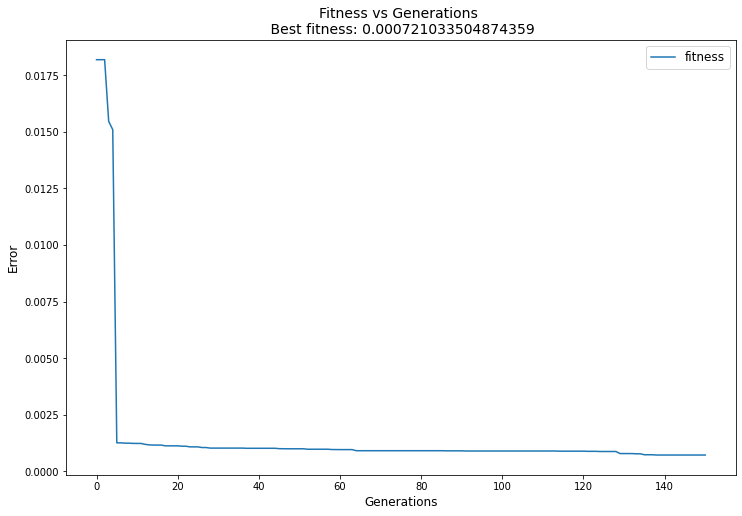

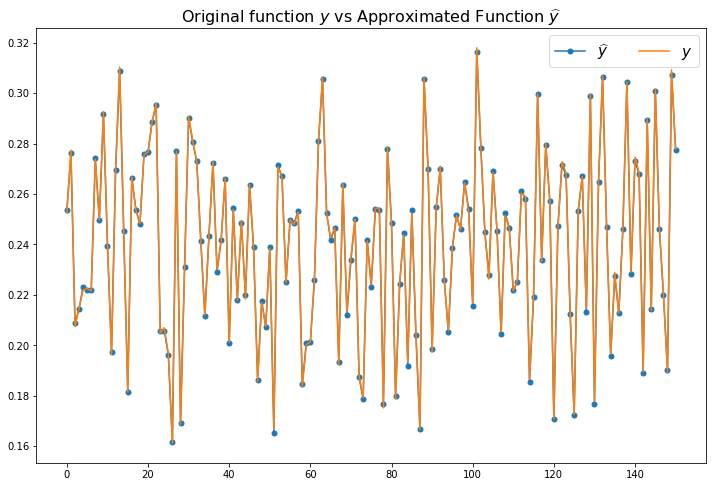

<IPython.core.display.Latex object>


*** RESULTS ***
E_MMX_TRAIN: 0.0015020384 	 E_RMS_TRAIN: 0.0007897013
E_MMX_TEST:  0.0019077516 	 E_RMS_TEST:  0.0008319356
E_MMX:       0.0019077516 	 E_RMS:       0.0007985542

C[0, 0, 0, 0, 0, 0] = 0.1412970476
C[0, 0, 1, 0, 0, 0] = 0.0685925065
C[0, 1, 0, 0, 0, 0] = 0.0692634381
C[1, 0, 0, 0, 0, 0] = 0.0620980297
C[1, 0, 0, 0, 2, 0] = 0.0108077950
C[1, 6, 8, 0, 8, 4] = 0.1461587456
C[2, 0, 0, 0, 1, 0] = -0.0045862638
C[2, 1, 4, 0, 0, 0] = -0.0055881853

Equation:
*** SUGGESTED TERMS ***

Mean attributions per term:

t1: Mean relative term attribution: 60.30%	 Mean term attribution: 0.141297047608532
t2: Mean relative term attribution: 13.28%	 Mean term attribution: 0.03315699591495427
t3: Mean relative term attribution: 14.77%	 Mean term attribution: 0.03642926225758172
t4: Mean relative term attribution: 11.30%	 Mean term attribution: 0.028266794531005692
t5: Mean relative term attribution: 0.68%	 Mean term attribution: 0.001722354120113621
t6: Mean relative term attribution: 0.0

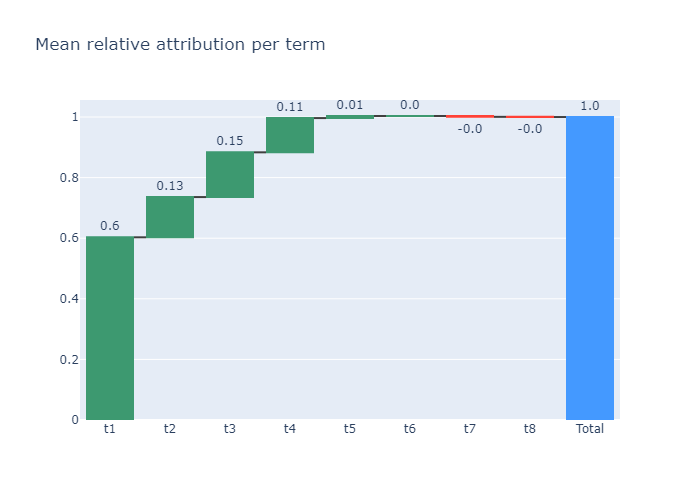

Suggested terms: ['term1', 'term2', 'term3', 'term4']


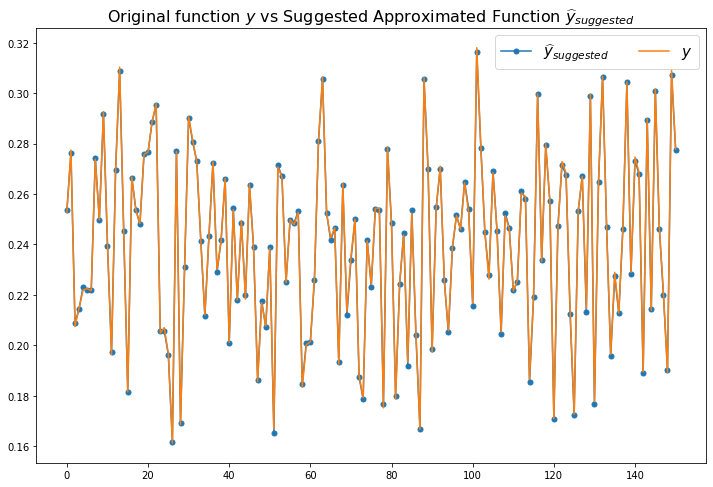


*** RESULTS - SUGGESTED ***
E_RMS: 	0.0016781436 
E_MMX: 	0.0038380487 

C[0, 0, 0, 0, 0, 0] = 0.1412970476
C[0, 1, 0, 0, 0, 0] = 0.0692634381
C[0, 0, 1, 0, 0, 0] = 0.0685925065
C[1, 0, 0, 0, 0, 0] = 0.0620980297

Suggested Equation:


<IPython.core.display.Latex object>

In [22]:
coef_unique,coef_values_unique,best_fitness = EGA_CV(data,n_individuals,cross_probability,mutation_probability,
           max_generations,n_terms,error='rms',max_degree=9,max_monomial_degree=81,
           distribution='normal',train_pp=0.8,randomly_split=True,
            stabilize_data=True,stabilize_factor=1/1e6,
           plot_res_fitness=True,plot_best_results=True,plot_sort=False,
           plot_errors=False,save_plots=False, save_name_plots='',
            save_results=True,save_name='results_EGA.txt',print_gens=False,
            suggested_polynomial=True, suggested_threshold=0.98)

## Ejecución del archivo py

Para ejecutar el programa es necesario ejecutar __EGA_FastAscentAlgorithm.py__, el cual le pedirá al usuario los parámetros _data_path_, _delimiter_, _n_individuals_, _cross_probability_, _mutation_probability, _max_degree_, _highest_monomial_degree_, _error_:

- _Input Data Filename:_ El usuario debe ingresar la dirección del archivo ya sea en formato _csv_ o _txt_.
- _Input separators type (, or tab):_ El usuario debe ingresar ',' en caso de que la separación de los datos sea con coma o 'tab' si es por tabulador. Una vez ingresado se guarda en la variable
- _Give the numbers of individuals (int):_ El usuario debe de ingresar el número de individuos en la población.
- _Give me the cross probability [0,1]:_ El usuario debe de ingresar la probabilidad de cruza.
- _Give me the mutation probability [0,1]:_ El usuario debe de ingresar la probabilidad de mutación.
- _Give me the number of generations (int):_ El usuario debe de ingresar el máximo número de generaciones, que funciona como condición de paro para el algoritmo EGA.
- _Give me the maximum allowed degree (int):_ El usuario debe de ingresar la potencia máxima que una variable puede tener.
- _Give me the highest monomial's degree (int):_ El usuario debe de ingresar el grado máximo que puede tener el monomio.
- _Give the error to minimize (rms/mmx):_ El usuario debe de ingresar el error a minimizar, ya sea $\varepsilon_{RMS}$ o $\varepsilon_{MMX}$. 

Después de que el usuario ingresa los parámetros de manera correcta se ejecuta la función __EGA_CV__, una vez finalizado se muestran las gráficas de fitness vs generación, los errores y la comparación de los resultados obtenidos, se imprime en consola  el $\varepsilon_\theta$ y $\varepsilon_{RMS}$ mínimo, los coeficientes $c_i$ y los coeficientes $c_i$ sugeridos por el análisis de atribuciones. Además se guardan en el directorio local un archivo con los resultados con el nombre _solution.txt_.

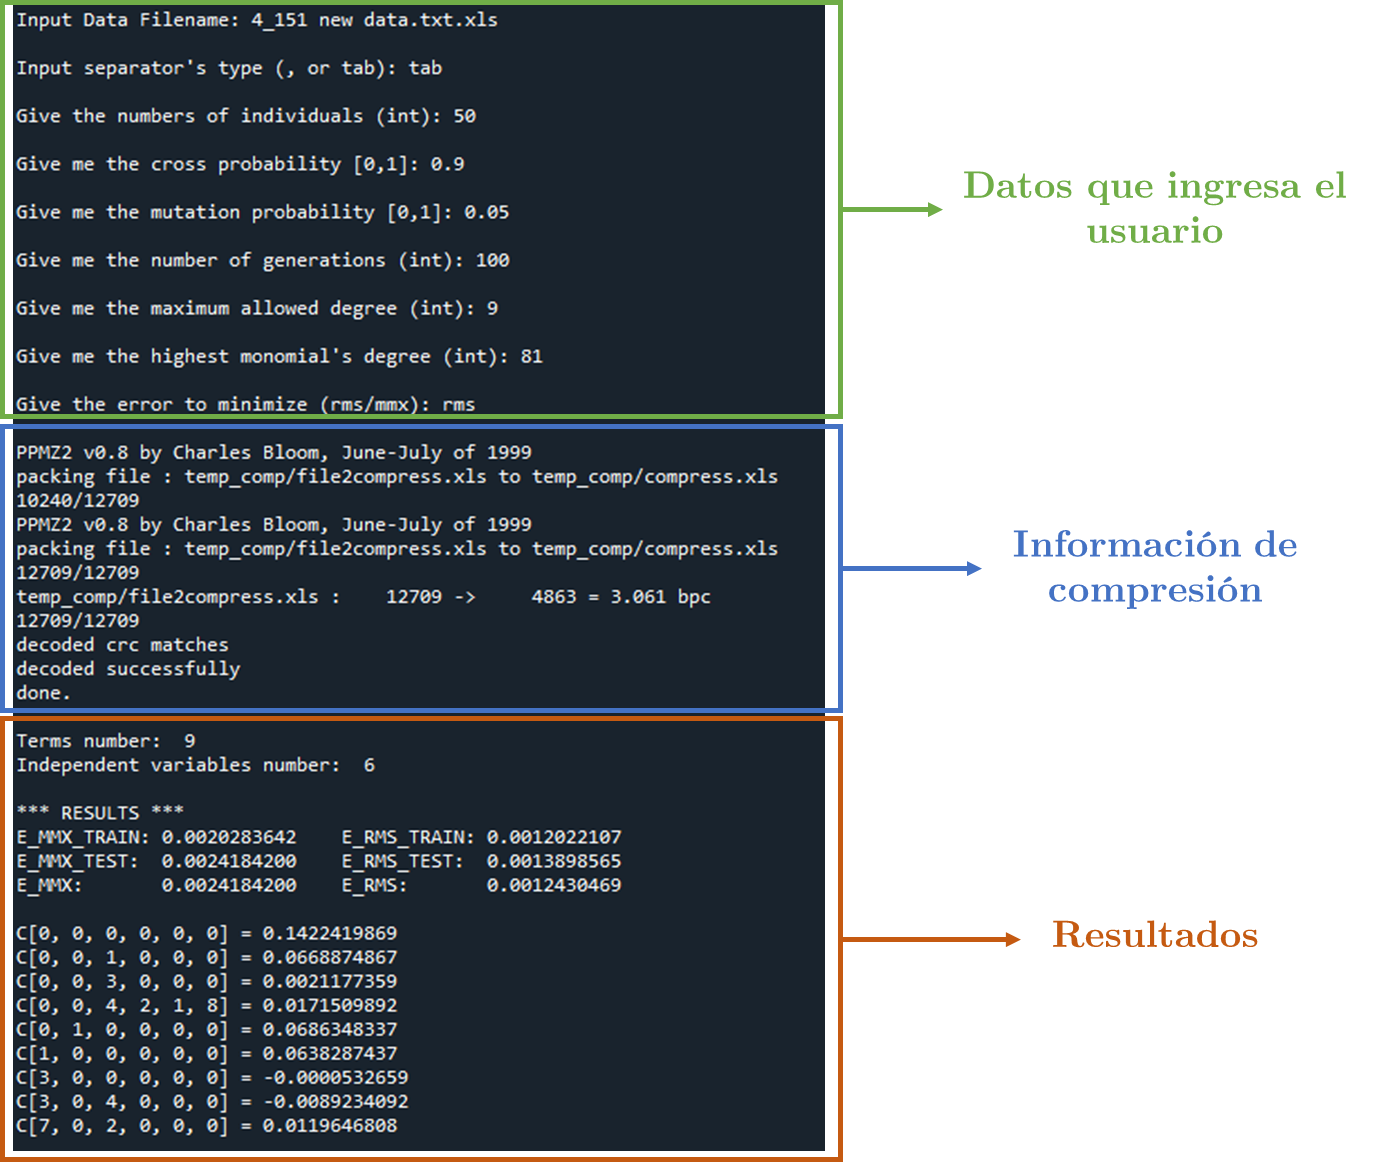
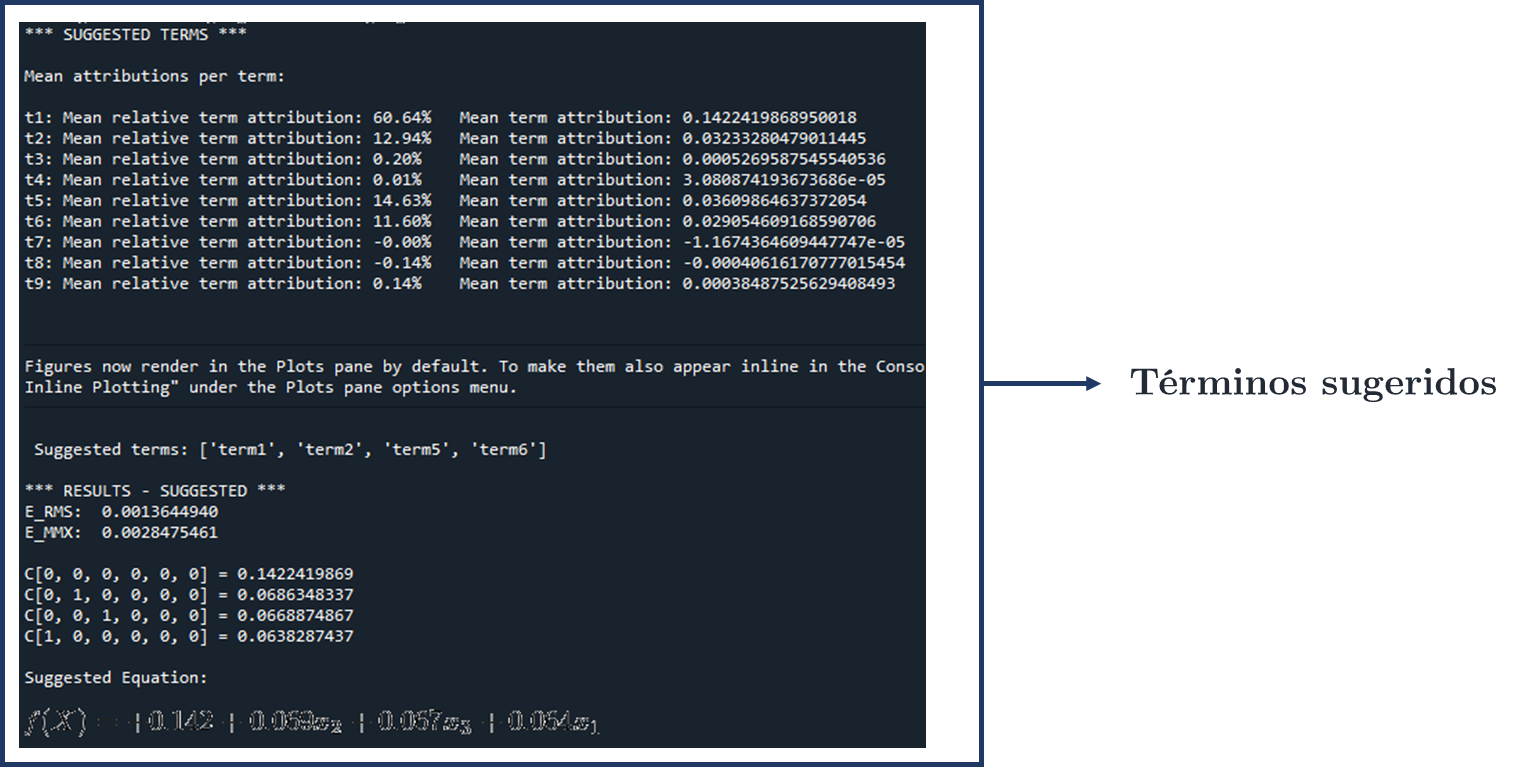